The `aca_psf_library` module will generate and access a set of PSF images generated from flight data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from astropy.table import Table
from mica.stats import guide_stats

In [2]:
%matplotlib inline

In [3]:
import aca_psf_library

A set of bright stars is used to generate the mean images.  The code used to select stars is included below
as this set is still being refined.

In [4]:
#guide_stars = aca_psf_library.get_obs_slots()
def get_obs_slots():
    """                                                                                                          
    Use the guide star database to get a Table of long-ish ER observations with bright stars tracked well        
    I've used the old n100_warm_frac as a proxy for expected low-ish dark current, though the residuals          
    probably support this just as well.  This doesn't check for dither-disabled explicitly; I'm hoping we'd be   
    sensitive to that via the check that there is good centroid coverage within the observation.                 
    """
    gs = Table(guide_stats.get_stats())
    gs['dur'] = gs['npnt_tstop'].astype(float) - gs['kalman_tstart']
    ok = ((gs['obsid'] > 38000)
          & (gs['dur'] > 30000)
          & (gs['sz'] == '8x8')
          & (gs['aoacmag_mean'] < 6.5)
          & (gs['f_track'] > .99)
          & (gs['dy_std'] < .2)
          & (gs['dz_std'] < .2)
      & (gs['n100_warm_frac'] < .10))
    return gs[ok]
guide_stars = get_obs_slots()

In [30]:
guide_stars[['obsid', 'kalman_datestart', 'dur', 'tccd_mean', 'aoacmag_mean', 'yang', 'zang']]

obsid,kalman_datestart,dur,tccd_mean,aoacmag_mean,yang,zang
int64,bytes21,float64,float64,float64,float64,float64
60670,2003:187:03:07:03.912,38880.301,-14.7281799316,6.43790626526,-567.0,-281.0
60233,2004:136:22:02:52.791,33318.652,-15.4522504807,5.77071809769,997.0,2093.0
59460,2005:249:15:50:34.656,33658.951,-15.599395752,6.29500341415,-892.0,-1528.0
58649,2006:347:06:39:37.020,35946.751,-18.4623279572,6.12496805191,1345.0,2028.0
58426,2007:111:20:48:35.851,32979.377,-19.5828075409,6.19875335693,-1226.0,1299.0
58400,2007:130:09:18:00.328,37000.451,-19.5828094482,6.06250333786,-1850.0,-821.0
58300,2007:209:14:23:21.555,51259.228,-19.5828094482,6.12499761581,-675.0,1701.0
57818,2008:132:23:57:26.161,44755.602,-19.5885601044,6.31467580795,-972.0,-731.0
57775,2008:159:10:08:59.472,33413.9770001,-19.5828094482,6.43747711182,374.0,-1717.0


The library code is presently binning the centroids from the observation into a 10x10 grid in a 1x1 pixel region in the center of the 8x8, stacking the images associated with the centroids centroid bins, and calculating mean/normalized pixel images for each stack.

The mean/normalized pixel image for each stack via this method is then averaged over the stars in the set.

In [6]:
master_psf, distributions = aca_psf_library.make_library(guide_stars)

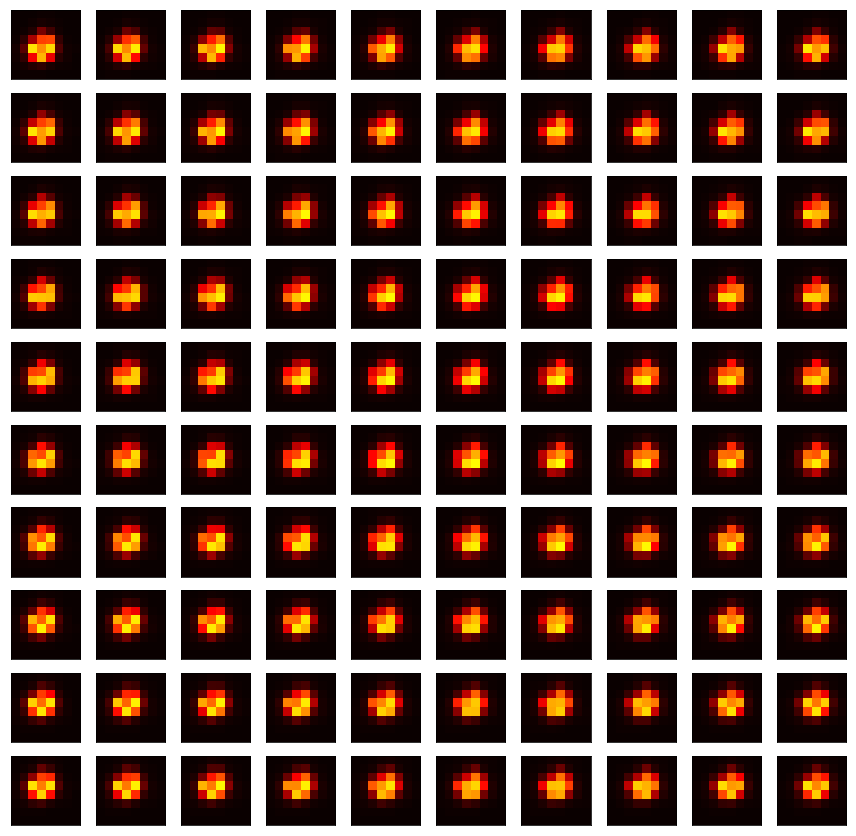

In [31]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(9, -1, -1):
    for j in range(9, -1, -1):
        axes[i][j].imshow(master_psf[(i, j)], cmap='hot', origin='lower', vmin=0, vmax=.18)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])